# Hybrid recommender system

The objetive of this project is to create a hybrid book recommendation system that combines three types of recommenders:
- **Simple recommender**
- Collaborative filtering engine
- Content-based recommenders

The dataset user is available at https://www.kaggle.com/arashnic/book-recommendation-dataset/version/1![image-2.png](attachment:image-2.png)

More information on the three types of recommenders available at https://www.datacamp.com/community/tutorials/recommender-systems-python (partial tutorial, using a different dataset).

This notebook implements the Simple recommender system.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load preprocessed data

In [2]:
books = pd.read_pickle("./pickle_files/d1_books.pkl")
ratings = pd.read_pickle("./pickle_files/d1_ratings.pkl")
users = pd.read_pickle("./pickle_files/d1_users.pkl")

# Determine book average rating

### Calculate average rating of each book

In [3]:
book_mean_rating = ratings[['ISBN','Book_Rating']].groupby('ISBN').mean()
book_mean_rating.head()

,Book_Rating
ISBN,
0330299891,3.0
0375404120,1.5
0586045007,0.0
9022906116,3.5
9032803328,0.0


### Add average rating to books DF

All processing will be done on 'books', presenving the original data in 'books_raw'

In [4]:
rated_books = books.merge(book_mean_rating, how='inner', on='ISBN')

All processing will be done on 'ratings', presenving the original data in 'ratings_raw'

In [5]:
rated_books.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Book_Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,0.000000
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,4.928571
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,5.000000
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,4.272727
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,0.000000


### Histogram of book ratings

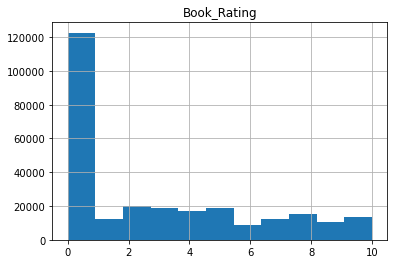

In [6]:
hist = rated_books.hist(bins=11,column='Book_Rating')

Most books have zero rating (inferred)

### Calculate number of votes per book

In [7]:
ratings.columns

Index(['User_ID', 'ISBN', 'Book_Rating'], dtype='object')

In [15]:
book_votes = ratings[['ISBN','User_ID']].groupby('ISBN').count()
book_votes.rename(columns={'User_ID':'Votes'}, inplace=True)
book_votes.head()

,Votes
ISBN,
0330299891,2
0375404120,2
0586045007,1
9022906116,2
9032803328,1


In [16]:
book_votes.sum(0) / book_votes.count(0)

Votes    3.376185
dtype: float64

Average book rating is 3.376185

In [17]:
book_votes.max(0)

Votes    2502
dtype: int64

### 10 most voted books

In [18]:
book_votes.nlargest(10, 'Votes')

,Votes
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723
044023722X,647
0679781587,639
0142001740,615
067976402X,614


### Let's get rid of books with too few votes

We'll keep only the books with 100 or more votes

In [22]:
book_votes.drop(book_votes.loc[book_votes.Votes <100].index, inplace=True)

In [23]:
book_votes = book_votes.sort_values('Votes')

In [25]:
book_votes.head(20)

,Votes
ISBN,
0140092323,100
0786866586,100
0385424736,100
0425151867,100
067100042X,100
0449203794,100
0425189864,100
0060916508,100
0312966806,100


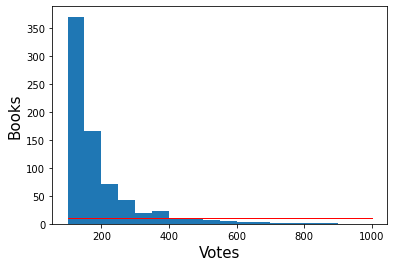

In [26]:
plt.hist(book_votes, bins = [100,150,200,250,300,350,400,450,500,550,600,700,800,900,1000]) 
plt.xlabel('Votes',fontsize=15)
plt.ylabel('Books',fontsize=15)
x = [100, 1000]
y = [10, 10]
plt.plot(x, y, color="red", linewidth=1)
plt.show()

The vast majority of books has fewer than 400 votes

### Add number of votes to 'books'

In [27]:
rated_books = rated_books.merge(book_votes, how='inner', on='ISBN')
rated_books.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Book_Rating,Votes
0,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,3.085308,422
1,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.0...,3.411111,180
2,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,1.019584,2502
3,0345402871,Airframe,Michael Crichton,1997,Ballantine Books,http://images.amazon.com/images/P/0345402871.0...,2.845411,207
4,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,3.761671,407


### Calculate the score of the book

In [28]:
C = rated_books['Book_Rating'].mean()
C

3.187460629101757

In [29]:
m = rated_books['Votes'].quantile(0.90)
m

320.4

In [30]:
# Function that computes the weighted rating of each book
def weighted_rating(x, m=m, C=C):
    v = x['Votes']
    R = x['Book_Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [31]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
rated_books['Score'] = rated_books.apply(weighted_rating, axis=1)

In [32]:
rated_books.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Book_Rating,Votes,Score
0,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,3.085308,422,3.129394
1,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.0...,3.411111,180,3.267910
2,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,1.019584,2502,1.265683
3,0345402871,Airframe,Michael Crichton,1997,Ballantine Books,http://images.amazon.com/images/P/0345402871.0...,2.845411,207,3.053209
4,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,3.761671,407,3.508747


## And best books are... (drumroll)

In [34]:
simple_recommender = rated_books.nlargest(20, 'Score')
simple_recommender

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Book_Rating,Votes,Score
468,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,6.541237,194,4.452299
386,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,6.467005,197,4.436147
474,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.0...,5.571856,334,4.404435
469,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439064864.0...,6.611765,170,4.374515
261,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,4.900175,571,4.284566
316,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,6.363095,168,4.279817
109,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,4.652322,883,4.262309
67,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,4.468726,1295,4.214598
5,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,4.920308,389,4.137669
511,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic,http://images.amazon.com/images/P/0439136369.0...,5.345133,226,4.079909


### Save to file

In [37]:
simple_recommender.to_pickle("./pickle_files/simple_recommender.pkl")

### End of preprocessing